In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
from scipy import stats
set_matplotlib_formats("svg")
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animations
from IPython.display import display, IFrame, HTML
import ipywidgets as widgets

def normal_curve(x, mu=0, sigma=1):
    return 1 / np.sqrt(2*np.pi) * np.exp(-(x - mu)**2/(2 * sigma**2))

def normal_area(a, b, bars=False, title=None):
    x = np.linspace(-4, 4)
    y = normal_curve(x)
    ix = (x >= a) & (x <= b)
    plt.plot(x, y, color='black')
    plt.fill_between(x[ix], y[ix], color='gold')
    if bars:
        plt.axvline(a, color='red')
        plt.axvline(b, color='red')
    if title:
        plt.title(title)
    else:
        plt.title(f'Area between {np.round(a, 2)} and {np.round(b, 2)}')
    plt.show()
    
def area_within(z):
    title = f'Proportion of values within {z} SDs of the mean: {np.round(stats.norm.cdf(z) - stats.norm.cdf(-z), 4)}'
    normal_area(-z, z, title=title)

def show_clt_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vTcJd3U1H1KoXqBFcWGKFUPjZbeW4oiNZZLCFY8jqvSDsl4L1rRTg7980nPs1TGCAecYKUZxH5MZIBh/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 509
    display(IFrame(src, width, height))

# Lecture 23 – The Central Limit Theorem, Choosing Sample Sizes

## DSC 10, Fall 2022

### Announcements

- Lab 7 is due **tomorrow at 11:59pm**.
- Homework 7 is due on **Tuesday 11/22 at 11:59pm**.
- The Final Project is due on **Tuesday 11/29 at 11:59pm**.

### Agenda

- The Central Limit Theorem.
- Using the CLT to create confidence intervals.
- Using CLT-based confidence intervals for hypothesis testing.
- Choosing sample sizes.

## The Central Limit Theorem

### The Central Limit Theorem

- The Central Limit Theorem (CLT) says that the probability distribution of the **sum or mean** of a large random sample drawn with replacement will be roughly normal, regardless of the distribution of the population from which the sample is drawn.

- The distribution of the sample mean is centered at the population mean, and its standard deviation is 

$$\text{SD of Distribution of Possible Sample Means} = \frac{\text{Population SD}}{\sqrt{\text{sample size}}}$$

- When we collect a single sample, we won't know the population mean or SD, so we'll use the sample mean and SD as approximations.

- **Key idea: The CLT allows us to estimate the distribution of the sample mean, given just a single sample, without having to bootstrap!**

In [2]:
show_clt_slides()

## Confidence intervals

### Confidence intervals

- Previously, we bootstrapped to construct confidence intervals.
    - Strategy: Collect one sample, repeatedly resample from it, calculate the statistic on each resample, and look at the middle 95% of resampled statistics.

- But, **if our statistic is the mean**, we can use the CLT.
    - Computationally cheaper – no simulation required!

- In both cases, we use just a single sample to construct our confidence interval.

### Constructing a 95% confidence interval through bootstrapping

Let's draw one sample then bootstrap to generate 2000 resample means.

In [3]:
np.random.seed(42)
delays = bpd.read_csv('data/delays.csv')
my_sample = delays.sample(500)

In [4]:
resample_means = np.array([])
repetitions = 2000

for i in np.arange(repetitions):
    resample = my_sample.sample(500, replace=True)
    resample_mean = resample.get('Delay').mean()
    resample_means = np.append(resample_means, resample_mean)
    
resample_means

array([12.65, 11.5 , 11.34, ..., 12.59, 11.89, 12.58])

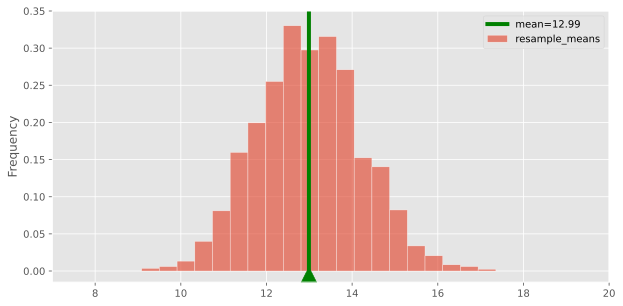

In [5]:
bpd.DataFrame().assign(resample_means=resample_means).plot(kind='hist', density=True, ec='w', alpha=0.65, bins=20, figsize=(10, 5));
plt.scatter([resample_means.mean()], [-0.005], marker='^', color='green', s=250)
plt.axvline(resample_means.mean(), color='green', label=f'mean={np.round(resample_means.mean(), 2)}', linewidth=4)
plt.xlim(7, 20)
plt.ylim(-0.015, 0.35)
plt.legend();

One approach to computing a confidence interval for the population mean involves taking the middle 95% of this distribution.

In [6]:
left_boot = np.percentile(resample_means, 2.5)
right_boot = np.percentile(resample_means, 97.5)
[left_boot, right_boot]

[10.7159, 15.43405]

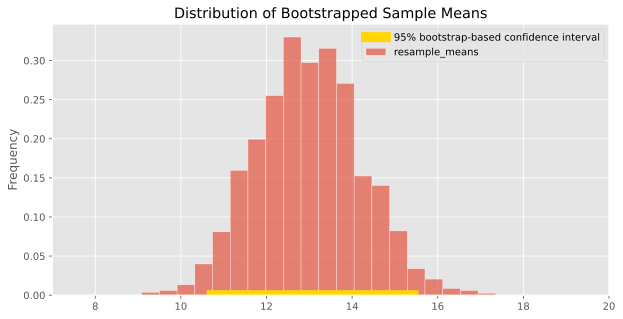

In [7]:
bpd.DataFrame().assign(resample_means=resample_means).plot(kind='hist', y='resample_means', alpha=0.65, bins=20, density=True, ec='w', figsize=(10, 5), title='Distribution of Bootstrapped Sample Means');
plt.plot([left_boot, right_boot], [0, 0], color='gold', linewidth=10, label='95% bootstrap-based confidence interval');
plt.xlim(7, 20);
plt.legend();

### Middle 95% of a normal distribution

But we didn't _need_ to bootstrap to learn what the distribution of the sample mean looks like. We could instead use the CLT, which tells us that the distribution of the sample mean is normal. Further, its mean and standard deviation are approximately:

In [8]:
samp_mean_mean = my_sample.get('Delay').mean()
samp_mean_mean

13.008

In [9]:
samp_mean_sd = np.std(my_sample.get('Delay')) / np.sqrt(my_sample.shape[0])
samp_mean_sd

1.2511114546674091

So, the distribution of the sample mean is approximately:

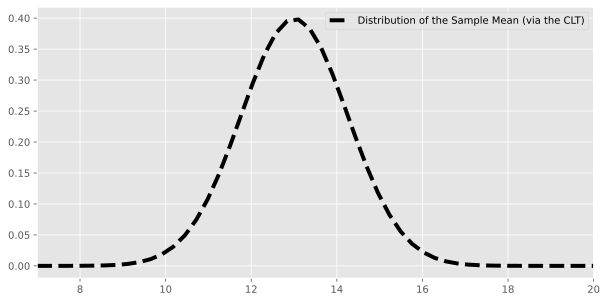

In [10]:
plt.figure(figsize=(10, 5))
norm_x = np.linspace(7, 20)
norm_y = normal_curve(norm_x, mu=samp_mean_mean, sigma=samp_mean_sd)
plt.plot(norm_x, norm_y, color='black', linestyle='--', linewidth=4, label='Distribution of the Sample Mean (via the CLT)')
plt.xlim(7, 20)
plt.legend();

**Question**: What interval on the $x$-axis captures the **middle 95%** of this distribution?

### Recall: Normal approximations

As we saw last class, if a variable is roughly normal, then approximately 95% of its values are within 2 standard deviations of its mean.

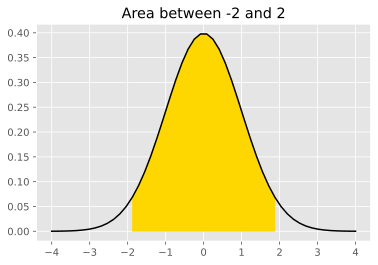

In [11]:
normal_area(-2, 2)

In [12]:
stats.norm.cdf(2) - stats.norm.cdf(-2)

0.9544997361036416

Let's use this fact here!

### Computing a 95% confidence interval using the CLT

- Approximately 95% of a normal curve's area falls within $\pm$ 2 SDs of the mean.
- 🚨 **Don't confuse the sample SD with the SD of the sample mean's distribution**!

$$\text{SD of Distribution of Possible Sample Means} \approx \frac{\text{Sample SD}}{\sqrt{\text{sample size}}}$$

In [13]:
my_delays = my_sample.get('Delay')
left_normal = my_delays.mean() - 2 * np.std(my_delays) / np.sqrt(500)
right_normal = my_delays.mean() + 2 * np.std(my_delays) / np.sqrt(500)
[left_normal, right_normal]

[10.50577709066518, 15.510222909334818]

### Visualizing the CLT-based confidence interval

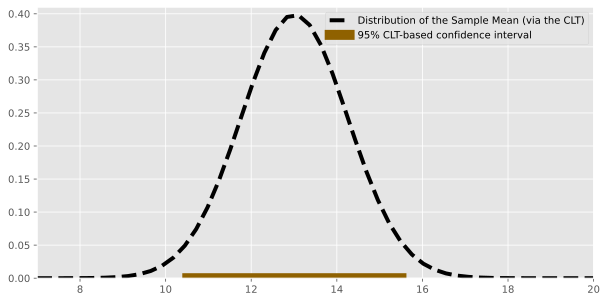

In [14]:
plt.figure(figsize=(10, 5))
norm_x = np.linspace(7, 20)
norm_y = normal_curve(norm_x, mu=samp_mean_mean, sigma=samp_mean_sd)
plt.plot(norm_x, norm_y, color='black', linestyle='--', linewidth=4, label='Distribution of the Sample Mean (via the CLT)')
plt.xlim(7, 20)
plt.ylim(0, 0.41)
plt.plot([left_normal, right_normal], [0, 0], color='#8f6100', linewidth=10, label='95% CLT-based confidence interval')
plt.legend();

### Comparing confidence intervals

We've constructed two confidence intervals for the population mean:

One using bootstrapping,

In [15]:
[left_boot, right_boot]

[10.7159, 15.43405]

and one using the CLT.

In [16]:
[left_normal, right_normal]

[10.50577709066518, 15.510222909334818]

In both cases, we only used information in `my_sample`, not the population.

The intervals created using each method are slightly different, because there are some approximations involved:
 - Bootstrap-based confidence intervals are approximate because they are based on an empirical distribution of many resample means, not all possible resample means.
 - CLT-based confidence intervals are approximate because the percentage of values that fall within 2 SDs of the mean in a normal distribution is approximately, but not exactly, 95%.
 

### Recap: Confidence intervals for the population mean

A 95% confidence interval for the population mean is given by

$$
\left[\text{sample mean} - 2\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}},
\text{sample mean} + 2\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}}
\right]
$$

This CI doesn't require bootstrapping, and it only requires three numbers – the sample mean, the sample SD, and the sample size!

### Bootstrapping vs. the CLT

Bootstrapping still has its uses!

| | Bootstrap | CLT |
| --- | --- | --- |
| **Pro** | Works for many sample statistics <br> (mean, median, standard deviation). | Only requires 3 numbers – <br>the sample mean, sample SD, and sample size. |
| **Con** | Very computationally expensive (requires drawing many, <br> many samples from the original sample). | Only works for the sample mean (and sum). | 

### Activity

We just saw that when $z = 2$, the following is a 95% confidence interval for the population mean.

$$
\left[\text{sample mean} - z\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}},
\text{sample mean} + z\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}}
\right]
$$

**Question**: What value of $z$ should we use to create an 80% confidence interval? 90%?

In [17]:
z = widgets.FloatSlider(value=2, min=0,max=4,step=0.05, description='z')
ui = widgets.HBox([z])
out = widgets.interactive_output(area_within, {'z': z})
display(ui, out)

Output()

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

Which one of these histograms corresponds to the distribution of the sample mean for samples of size 100 drawn from a population with mean 50 and SD 20?

<center><img src='data/which-histogram.png' width=900></center>

## Hypothesis testing, revisited

### Hypothesis testing for the mean

- Before, we bootstrapped to create confidence intervals, which we could use for hypothesis tests.
- We can do the same thing with our CLT-based confidence intervals, as well.

### Using a confidence interval for hypothesis testing

- **Null Hypothesis**: The population parameter is equal to some value, $x$.
- **Alternative Hypothesis**: The population parameter is not equal to $x$.
- Cutoff for p-value: p%.

- Strategy:
    - Construct a (100-p)% confidence interval for the population parameter.
    - If $x$ is not in the interval, we reject the null hypothesis.
    - If $x$ is in the interval, we fail to reject the null hypothesis (since our results are consistent with the null).

### Example: Body temperature 🌡

- It is widely accepted that the mean human body temperature is 98.6 ºF (or 37 ºC).
- We have a dataset of body temperatures, and want to see if our data set is consistent with that belief.

In [18]:
temperatures = bpd.read_csv('data/temp.csv')
temperatures

,temperature
0,96.3
1,96.7
2,96.9
...,...
127,99.9
128,100.0
129,100.8


In [19]:
temperatures.get('temperature').describe()

count    130.00
mean      98.25
std        0.73
          ...  
50%       98.30
75%       98.70
max      100.80
Name: temperature, Length: 8, dtype: float64

### Setting up a hypothesis test

- **Null Hypothesis**: The mean body temperature of all people is 98.6 ºF.
- **Alternative Hypothesis**: The mean body temperature of all people is not 98.6 ºF.

The mean body temperature of all people is a population mean!

### CI for mean body temperature

 - A 95% confidence interval for population mean is given by:

$$
\left[
\text{sample mean} - 2\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}}, \
\text{sample mean} + 2\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}}
\right]
$$

- Thanks to the CLT, we have an understanding of the distribution of the sample mean, even though we don't know anything about the distribution of body temperatures. 
- We **don't** need to assume that body temperatures are normally distributed to use the CLT!

In [20]:
sample_mean = temperatures.get('temperature').mean()
sample_mean

98.24923076923076

In [21]:
sample_mean_sd = np.std(temperatures.get('temperature')) / np.sqrt(temperatures.shape[0])
sample_mean_sd

0.06405661469519337

In [22]:
# 95% confidence interval for the mean body temperature of all people:
[sample_mean - 2 * sample_mean_sd, sample_mean + 2 * sample_mean_sd]

[98.12111753984037, 98.37734399862116]

**Careful!** This doesn't mean that 95% of temperatures in our sample (or the population) fall in this range!

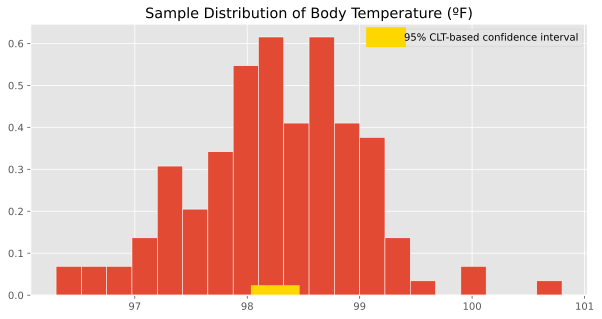

In [23]:
plt.figure(figsize=(10, 5))
plt.hist(temperatures.get('temperature'), density=True, bins=20, ec='w');
plt.title('Sample Distribution of Body Temperature (ºF)');
plt.plot([sample_mean - 2*sample_mean_sd, sample_mean + 2*sample_mean_sd], [0, 0], color='gold', linewidth=20, label='95% CLT-based confidence interval')
plt.legend();

### Conclusion

In [24]:
# 95% confidence interval for the mean body temperature of all people:
[sample_mean - 2 * sample_mean_sd, sample_mean + 2 * sample_mean_sd]

[98.12111753984037, 98.37734399862116]

- Using the standard p-value cutoff of 0.05, we reject the null hypothesis because 98.6 ºF is not in the 95% confidence interval for mean body temperature.

- What happened?
    - 98.6 ºF is due to Carl Reinhold August Wunderlich, a 19th century physician, who conducted a study when thermometers were new.
    - [This LA Times article](https://www.latimes.com/archives/la-xpm-2007-nov-26-he-esoterica26-story.html) states that it's likely that Wunderlich's thermometer was miscalibrated.
    - [A recent article by the Yale School of Medicine](https://www.yalemedicine.org/news/temperature-checks-covid) states that the average body temperature has declined slightly over the last 150 years by 1.5 ºF, and that body temperature depends on the time of day, age, and sex, among other things.

## Choosing sample sizes

<center><img src="data/bereal.png" width=60%></center>

### Example: Polling

- You want to estimate the proportion of UCSD students that use BeReal.

- To do so, you will ask a random sample of UCSD students whether or not they use BeReal.

- You want to create a confidence interval that has:
    - A 95% confidence level.
    - A width of at most 0.06.
        - The interval (0.21, 0.25) would be fine, but the interval (0.21, 0.28) would not.

**Question**: How big of a sample do you need? 🤔

### Aside: Proportions are just means

- The sample we collect will consist of only two unique values:
    - 1, if the student uses BeReal.
    - 0, if they don't use BeReal.

- We're interested in the proportion of values in our sample that are 1.

- This proportion is the same as the mean of our sample!

- For instance, suppose our sample is $0, 1, 1, 0, 1$. Then $\frac{3}{5}$ of the values are $1$. The sample mean is

$$\frac{0 + 1 + 1 + 0 + 1}{5} = \frac{3}{5}$$

**Key takeaway**: The CLT applies in this case as well! The distribution of the proportion of 1s in our sample is roughly normal.

### Our strategy

We will:

1. Collect a random sample.
2. Compute the sample mean (i.e., the proportion of people who say "yes").
3. Compute the sample standard deviation.
4. Construct a 95% confidence interval for the population mean:

$$
\left[
\text{sample mean} - 2\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}}, \
\text{sample mean} + 2\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}}
\right]
$$

Note that the width of our CI is the right endpoint minus the left endpoint:

$$
\text{width} = 4 \cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}}
$$

### Our strategy

- We want a CI whose width is at most 0.06.

$$\text{width} = 4 \cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}}$$

- The width of our confidence interval depends on two things: the sample SD and the sample size.

- If we know the sample SD, we can find the appropriate sample size by re-arranging the following inequality:

$$4 \cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}} \leq 0.06$$

$$\sqrt{\text{sample size}} \geq 4 \cdot \frac{\text{sample SD}}{0.06} \\
\implies \boxed{\text{sample size} \geq \left( 4 \cdot \frac{\text{sample SD}}{0.06} \right)^2}$$

- **Problem**: Before polling, we don't know the sample SD, because we don't have a sample! We don't know the population SD either.

- **Solution**: Find an upper bound – i.e. the largest possible value – for the sample SD and use that.

### Upper bound for the standard deviation of a sample

- Without any information about the values in a sample, we can't make any guarantees about the standard deviation of the sample.

- However, in this case, we know that the only values in our sample will be 0 ("no") and 1 ("yes").

- In Homework 7, we introduced a formula for the standard deviation of a collection of 1s and 0s:

$$\text{SD of Collection of 0s and 1s} = \sqrt{(\text{Prop. of 0s}) \times (\text{Prop. of 1s})}$$

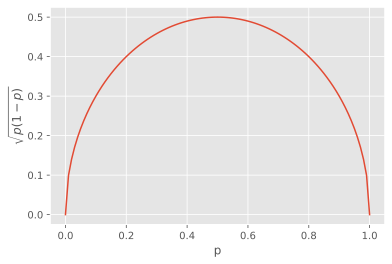

In [25]:
# Plot the SD of a collection of 0s and 1s with p proportion of Os.
p = np.arange(0, 1.01, 0.01)
sd = np.sqrt(p * (1 - p))
plt.plot(p, sd)
plt.xlabel('p')
plt.ylabel(r'$\sqrt{p(1-p)}$');

- **Fact**: The largest possible value of the SD of a collection of 0s and 1s is 0.5. (This happens when half the values are 0 and half are 1.)

### Choosing a sample size

- In the sample we will collect, the maximum possible SD is 0.5.

- Earlier, we saw that to construct a confidence interval with the desired confidence level and width, our sample size needs to satisfy:

$$\text{sample size} \geq \left( 4 \cdot \frac{\text{sample SD}}{0.06} \right)^2$$

- Notice that as the sample SD increases, the required sample size increases.

- By using the maximum possible SD above, **we ensure that we collect a large enough sample, no matter what the population and sample look like**.

### Choosing a sample size

$$\text{sample size} \geq \left( 4 \cdot \frac{\text{sample SD}}{0.06} \right)^2$$

By substituting 0.5 for the sample size, we get

$$\text{sample size} \geq \left( 4 \cdot \frac{\text{0.5}}{0.06} \right)^2$$

While any sample size that satisfies the above inequality will give us a confidence interval that satisfies the necessary properties, it's time-consuming to gather larger samples than necessary. So, we'll pick the **smallest sample size that satisfies the above inequality**.

In [26]:
(4 * 0.5 / 0.06) ** 2

1111.1111111111113

**Conclusion:** We must sample **1112 people** to construct a 95% CI for the population mean that is at most 0.06 wide.

### Activity

Suppose we instead want an a 95% CI for the population mean that is at most 0.03 wide. What is the smallest sample size we could collect?

*Hint*: Use the fact that we must sample 1112 people for a 95% CI for the population mean that is at most 0.06 wide.

<br>

<details><summary>Click <b>here</b> to see the answer <b>after</b> you've attempted the question yourself.</summary>

$\text{sample size} \geq \left( 4 \cdot \frac{\text{0.5}}{0.03} \right)^2 = 4444.44..$, so the smallest sample size we could collect is 4445.
    
</details>

## Summary, next time

### Summary

- A 95% confidence interval for the population mean is given by

$$
\left[\text{sample mean} - 2\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}},
\text{sample mean} + 2\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}}
\right]
$$

- If we want to construct a confidence interval of a particular width and confidence level for a population _proportion_:
    1. Choose a confidence level (e.g. 95%) and maximum width (e.g. 0.06).
    2. Solve for the minimum sample size that satisfies both conditions.
    3. Collect a sample of that size.
    4. Use the formula above to construct an interval.

### What we've learned about inference

At a high level, the second half of this class has been about **statistical inference** – using a sample to draw conclusions about the population.

- To test whether a sample came from a known population distribution, use "standard" hypothesis testing. 

- To test whether two samples came from the same unknown population distribution, use permutation testing.

- To estimate a population parameter given a single sample, construct a confidence interval using bootstrapping (for most statistics) or the CLT (for the sample mean).

- To test whether a population parameter is equal to a particular value, $x$, construct a confidence interval using bootstrapping (for most statistics) or the CLT (for the sample mean), and check whether $x$ is in the interval.

### Next time

- We'll switch our focus to **prediction** – given a sample, what can I predict about data not in that sample?
- In the next 3 lectures, we'll focus on **linear regression**, a prediction technique that tries to find the best "linear relationship" between two numerical variables.
    - Along the way, we'll address another idea – **correlation**.
    - You will see linear regression in many more courses – it is one of the most important tools in the data science toolkit.